In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set_theme()

from named_entity_recognition.utils import read_dataset

### Dataset reading

In [2]:
langs = ['de'] # language (de) with its fractions in final dataset
fracs = [0.629]
panx_ch = read_dataset(langs=langs, fracs=fracs)

### Dataset size

In [3]:
pd.DataFrame({f'{l}_{s}': [panx_ch[l][s].num_rows] for l in langs for s in ['train', 'validation', 'test']})

,de_train,de_validation,de_test
0,12580,6290,6290


In [4]:
for k, v in panx_ch['de']['train'][0].items():
    print(f'{k}: {v}')

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [5]:
for k, v in panx_ch['de']['train'].features.items():
    print(f'{k}: {v}')

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


### Tagging - integer to string

In [6]:
tags = panx_ch['de']['train'].features['ner_tags'].feature

In [7]:
def tags_int_to_str(batch, tags=tags):
    return {'ner_tags_str': [tags.int2str(tag_int) for tag_int in batch['ner_tags']]}

panx_ch['de'] = panx_ch['de'].map(tags_int_to_str)
panx_ch['de']

Map:   0%|          | 0/12580 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [8]:
data_example = panx_ch['de']['train'][0]
pd.DataFrame(
    data={'tokens': data_example['tokens'], 'ner_tags_str': data_example['ner_tags_str']}
).T

,0,1,2,3,4,5,6,7,8,9,10,11
tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
ner_tags_str,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


### Tags amount

In [9]:
tags_amount_de = pd.DataFrame()
for s in ['train', 'validation', 'test']:
    tags_amount_de[s] = dict(Counter([
        _tag[2:] for _tags in panx_ch['de'][s]['ner_tags_str'] for _tag in _tags if _tag.startswith('B-')
    ]))
tags_amount_de.T

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


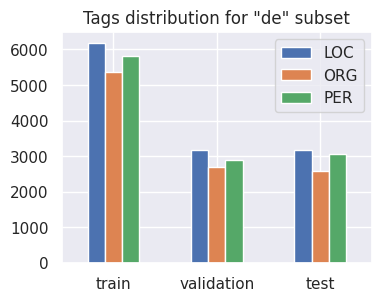

In [10]:
_ = tags_amount_de.T.plot.bar(title='Tags distribution for "de" subset', rot=0, figsize=(4, 3))